#  프로젝트: CAM을 만들고 평가해 보자

## * Get data&Preprocess

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [2]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [3]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [6]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

## * Generator a CAM image

40


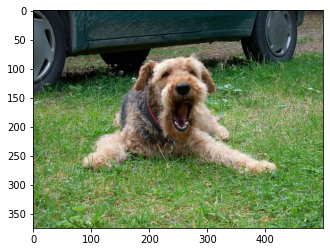

In [7]:
#새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

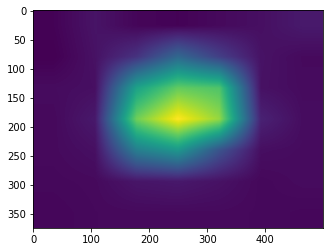

In [9]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

## * Make a method for blending

 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [29]:

def visualize_cam_on_image(image, cam_image):
    a=0.7
    width=image.shape[1]
    height=image.shape[0]
    cam_image=cv.resize(cam_image,(width,height))
    
    b=1.0 - a
    merged_image = cv2.addWeighted(image,a,cam_image,b,0.0)
#     cv.imshow('dst',dst)
#     cv.waitKey(0)
    
#     merged_image = None
    return merged_image

# def visualize_cam_on_image(src1, src2, alpha=0.5):
#     beta = (1.0 - alpha)
#     merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
#     return merged_image



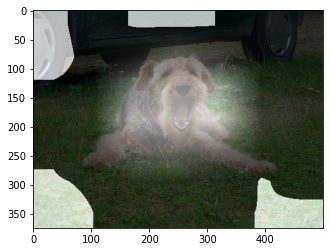

In [30]:
# visualize_cam_on_image() 함수 사용

# type(item['image'].numpy())

origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

# origin_image = item['image'].astype(np.uint8)
# cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
# plt.imshow(blended_image)
# plt.show()

## * Implement Grad-CAM

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image


In [ ]:
# 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

In [ ]:
# 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.